In [1]:
import os

# Check what's in the input folder
input_path = "/kaggle/input/telecom-churn-datasets"
print("Available files:")
for f in os.listdir(input_path):
    print(f"  - {f}")

Available files:
  - churn-bigml-20.csv
  - churn-bigml-80.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports complete!")

✅ Imports complete!


In [3]:
# Load the dataset (adjust filename based on Cell 1 output)
df = pd.read_csv(f"{input_path}/churn-bigml-80.csv")  # or churn-bigml-20.csv

print(f"Shape: {df.shape}")
print(f"\nColumns:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nTarget distribution:\n{df['Churn'].value_counts()}")

Shape: (2666, 20)

Columns:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

First 5 rows:
  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   

In [4]:
# Check target column name (might be 'Churn' or 'churn')
target_col = 'Churn' if 'Churn' in df.columns else 'churn'

# Convert target to binary if needed
if df[target_col].dtype == object:
    y = df[target_col].map({'False.': 0, 'True.': 1, 'No': 0, 'Yes': 1, False: 0, True: 1})
else:
    y = df[target_col]

# Separate features
X = df.drop(target_col, axis=1)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Target: {target_col}")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nTarget distribution:\n{y.value_counts()}")

Target: Churn
Numeric features (16): ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']
Categorical features (3): ['State', 'International plan', 'Voice mail plan']

Target distribution:
Churn
False    2278
True      388
Name: count, dtype: int64


In [5]:
# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("✅ Preprocessor created!")

✅ Preprocessor created!


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"\nTrain target:\n{y_train.value_counts(normalize=True)}")

Train: (2132, 19)
Test: (534, 19)

Train target:
Churn
False    0.854597
True     0.145403
Name: proportion, dtype: float64


In [7]:
# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

print("✅ Pipelines created!")

✅ Pipelines created!


In [8]:
# Parameter grids
lr_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Train Logistic Regression
print("Training Logistic Regression...")
lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)
print(f"Best LR F1: {lr_grid.best_score_:.4f}")
print(f"Best params: {lr_grid.best_params_}")

# Train Random Forest
print("\nTraining Random Forest...")
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print(f"Best RF F1: {rf_grid.best_score_:.4f}")
print(f"Best params: {rf_grid.best_params_}")

Training Logistic Regression...
Best LR F1: 0.4996
Best params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Training Random Forest...
Best RF F1: 0.7890
Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [9]:
# Select best model
if lr_grid.best_score_ > rf_grid.best_score_:
    best_model = lr_grid.best_estimator_
    model_name = "LogisticRegression"
    print(f"\n🏆 Best: Logistic Regression")
else:
    best_model = rf_grid.best_estimator_
    model_name = "RandomForest"
    print(f"\n🏆 Best: Random Forest")

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


🏆 Best: Random Forest

Accuracy: 0.9345
F1 Score: 0.7552
ROC-AUC: 0.8758

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.95      0.98      0.96       456
       Churn       0.83      0.69      0.76        78

    accuracy                           0.93       534
   macro avg       0.89      0.83      0.86       534
weighted avg       0.93      0.93      0.93       534



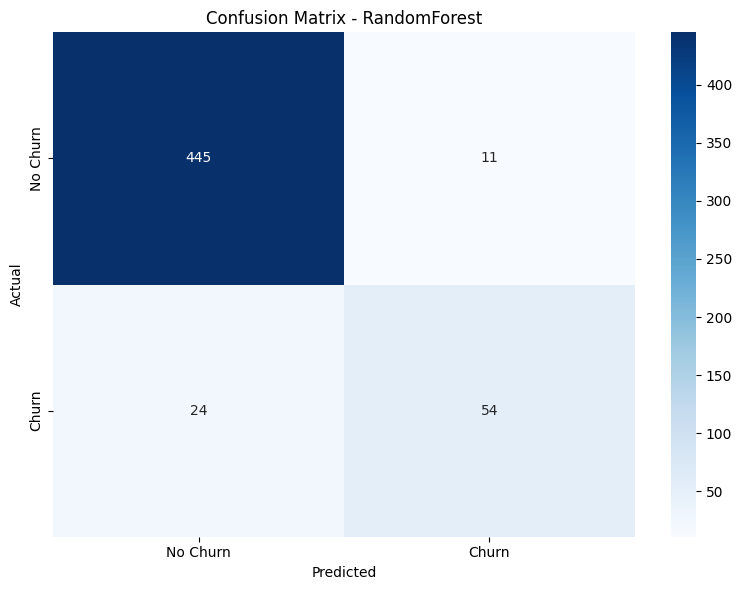

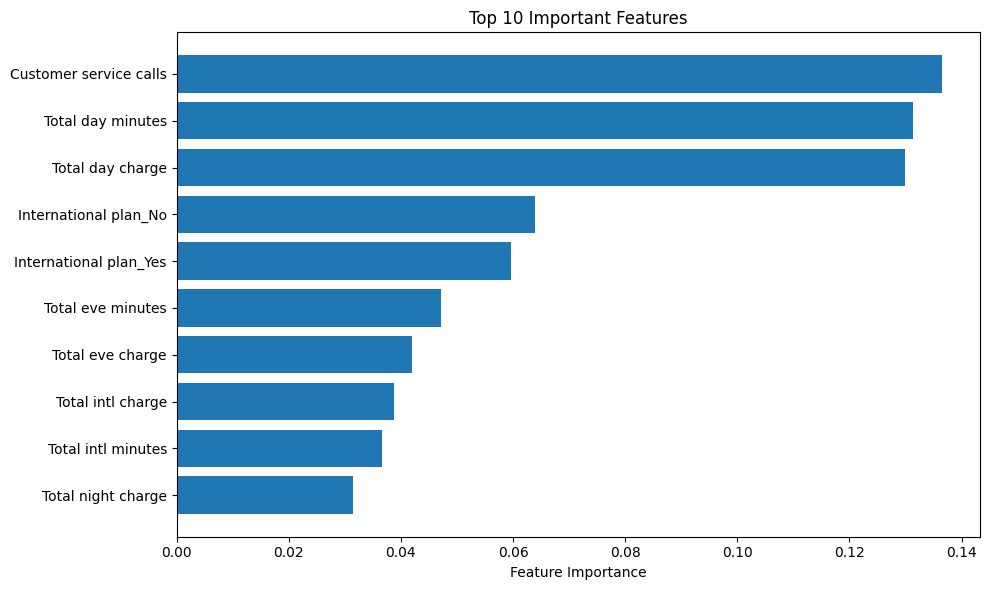

In [10]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300)
plt.show()

# Feature Importance (if Random Forest)
if model_name == "RandomForest":
    feature_names = (numeric_features + 
                    list(best_model.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_features)))
    
    importances = best_model.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()

In [11]:
# Save model
output_file = f"churn_pipeline_{model_name.lower()}.joblib"
joblib.dump(best_model, output_file)

print(f"✅ Saved: {output_file}")

# Verify
loaded_model = joblib.load(output_file)
test_pred = loaded_model.predict(X_test[:3])
print(f"Test load: {test_pred}")

# File size
import os
size_mb = os.path.getsize(output_file) / (1024*1024)
print(f"Size: {size_mb:.2f} MB")

✅ Saved: churn_pipeline_randomforest.joblib
Test load: [False False False]
Size: 1.40 MB


In [12]:
inference_script = f'''
import joblib
import pandas as pd

# Load pipeline
model = joblib.load("{output_file}")

# Example customer
new_customer = pd.DataFrame([{{
    # Fill with actual column names and sample values from your dataset
}}])

prediction = model.predict(new_customer)
probability = model.predict_proba(new_customer)

print(f"Churn: {{'Yes' if prediction[0] == 1 else 'No'}}")
print(f"Probability: {{probability[0][1]:.2%}}")
'''

with open("inference_example.py", "w") as f:
    f.write(inference_script)

print("✅ Created inference_example.py")

✅ Created inference_example.py


In [13]:
# List files to download
import os
files = [f for f in os.listdir("/kaggle/working/") if f.endswith(('.joblib', '.png', '.py'))]
print("Files to download:")
for f in files:
    size = os.path.getsize(f"/kaggle/working/{f}") / 1024
    print(f"  - {f} ({size:.1f} KB)")

Files to download:
  - confusion_matrix_RandomForest.png (86.4 KB)
  - inference_example.py (0.4 KB)
  - churn_pipeline_randomforest.joblib (1430.6 KB)
  - feature_importance.png (134.3 KB)


In [17]:
import shutil
import os

# Create output directory
output_dir = "/kaggle/working/churn-pipeline-deployment"
os.makedirs(output_dir, exist_ok=True)

# Get model name in lowercase
model_name_lower = model_name.lower()

# Copy files
files_to_copy = [
    "churn_pipeline_" + model_name_lower + ".joblib",
    "confusion_matrix_" + model_name + ".png",
    "inference_example.py"
]

if model_name == "RandomForest" and os.path.exists("/kaggle/working/feature_importance.png"):
    files_to_copy.append("feature_importance.png")

for file in files_to_copy:
    src = "/kaggle/working/" + file
    if os.path.exists(src):
        shutil.copy(src, output_dir)
        print("Copied: " + file)

# Get metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

# Create README without f-strings
readme_lines = [
    "# Churn Prediction Pipeline",
    "",
    "## Model: " + model_name,
    "",
    "### Performance",
    "- Accuracy: " + str(round(acc, 4)),
    "- F1 Score: " + str(round(f1, 4)),
    "- ROC-AUC: " + str(round(roc, 4)),
    "",
    "### Files",
    "- churn_pipeline_" + model_name_lower + ".joblib: Trained pipeline",
    "- confusion_matrix_" + model_name + ".png: Evaluation visualization",
    "- inference_example.py: Usage example",
    "",
    "### Usage",
    "```python",
    "import joblib",
    "import pandas as pd",
    "",
    'model = joblib.load("churn_pipeline_' + model_name_lower + '.joblib")',
    "prediction = model.predict(new_data)",
    "```"
]

readme_content = "\n".join(readme_lines)

with open(output_dir + "/README.md", "w") as f:
    f.write(readme_content)

print("Created README.md")

# Create ZIP
zip_path = "/kaggle/working/churn-pipeline-deployment"
shutil.make_archive(zip_path, 'zip', output_dir)

print("ZIP created: " + zip_path + ".zip")

# Show contents
print("\nZIP Contents:")
for f in os.listdir(output_dir):
    size = os.path.getsize(output_dir + "/" + f) / 1024
    print("  - " + f + " (" + str(round(size, 1)) + " KB)")

Copied: churn_pipeline_randomforest.joblib
Copied: confusion_matrix_RandomForest.png
Copied: inference_example.py
Copied: feature_importance.png
Created README.md
ZIP created: /kaggle/working/churn-pipeline-deployment.zip

ZIP Contents:
  - confusion_matrix_RandomForest.png (86.4 KB)
  - inference_example.py (0.4 KB)
  - churn_pipeline_randomforest.joblib (1430.6 KB)
  - feature_importance.png (134.3 KB)
  - README.md (0.4 KB)
